In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing important libraries

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

## Unzipping the files

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "../input/data-science-bowl-2018/stage1_train.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_train") 
    print('Done!') 

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "../input/data-science-bowl-2018/stage1_test.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_test") 
    print('Done!') 

## Performing preprocessing, Loading the data, and Getting data ready for our model

In [ ]:
TRAIN_PATH="stage1_train/"
TEST_PATH='stage1_test/'

In [ ]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]
print(len(train_ids))

In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

## Having a look at our training images and the segmented images related to it respectively

In [ ]:
image_x=random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))

plt.show()

In [ ]:
seed=42
np.random.seed=seed

## Building a U-Net

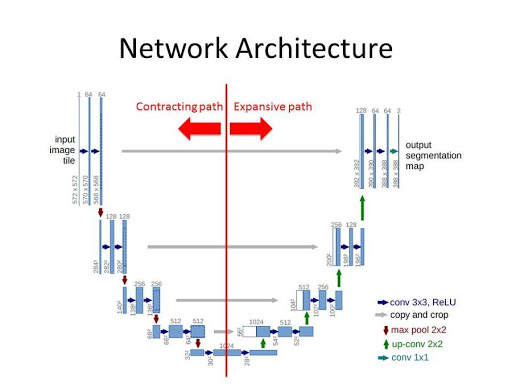

### Introduction:
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

The U-Net architecture stems from the so-called “fully convolutional network” first proposed by Long and Shelhamer.

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.

One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture. The network only uses the valid part of each convolution without any fully connected layers. To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. This tiling strategy is important to apply the network to large images, since otherwise the resolution would be limited by the GPU memory.

Source: https://en.wikipedia.org/wiki/U-Net

In [ ]:

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
modelu = tf.keras.Model(inputs=[inputs], outputs=[outputs])
modelu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelu.summary()


In [ ]:
#callbacks
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]

## Training the model

In [ ]:
results=model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=30,callbacks=callbacks)

## Applying the segmentation on the test images using our trained model.

In [ ]:
predict_test=model.predict(X_test,verbose=1)

In [ ]:
predict_test_t=(predict_test>0.5).astype(np.uint8)

In [ ]:
imshow(X_test[1])
plt.show()
imshow(np.mean(predict_test_t[1], axis=2))
plt.show()

In [ ]:
imshow(X_test[2])
plt.show()
imshow(np.mean(predict_test_t[2], axis=2))
plt.show()

## Building a Double Unet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_model((128, 128, 3))
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
results=model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=30,callbacks=callbacks)

In [ ]:
predict_test=model.predict(X_test,verbose=1)

In [ ]:
predict_test_t=(predict_test>0.5).astype(np.uint8)

In [ ]:
X_test.shape
predict_test_t.shape

In [ ]:
plt.imshow(X_test[1])
plt.show()
plt.imshow(np.mean(predict_test_t[1], axis=2))
plt.show()

In [ ]:
imshow(X_test[2])
plt.show()
imshow(np.mean(predict_test_t[2], axis=2))
plt.show()